# Take care of yourself! =)

On this kernel, I'll try to find the best features with two different methodologies: 
1. **Intuition** from correlation data.
2. **SelectKBest** algorithm.

Which one is better? What will the difference between performances be?

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19/dataset.xlsx


In [2]:
# packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

In [3]:
# loading file
df = pd.read_excel(r'/kaggle/input/covid19/dataset.xlsx')

In [4]:
# initial exploring data
df.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.columns

Index(['Patient ID', 'Patient age quantile', 'SARS-Cov-2 exam result',
       'Patient addmited to regular ward (1=yes, 0=no)',
       'Patient addmited to semi-intensive unit (1=yes, 0=no)',
       'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit',
       'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       ...
       'Hb saturation (arterial blood gases)',
       'pCO2 (arterial blood gas analysis)',
       'Base excess (arterial blood gas analysis)',
       'pH (arterial blood gas analysis)',
       'Total CO2 (arterial blood gas analysis)',
       'HCO3 (arterial blood gas analysis)',
       'pO2 (arterial blood gas analysis)', 'Arteiral Fio2', 'Phosphor',
       'ctO2 (arterial blood gas analysis)'],
      dtype='object', length=111)

In [6]:
# Patient ID isn't necessary
df = df.drop(columns='Patient ID')

In [7]:
# Are there blank?
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [8]:
# Searching for NaNs
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 110 columns):
Patient age quantile                                     5644 non-null int64
SARS-Cov-2 exam result                                   5644 non-null object
Patient addmited to regular ward (1=yes, 0=no)           5644 non-null int64
Patient addmited to semi-intensive unit (1=yes, 0=no)    5644 non-null int64
Patient addmited to intensive care unit (1=yes, 0=no)    5644 non-null int64
Hematocrit                                               603 non-null float64
Hemoglobin                                               603 non-null float64
Platelets                                                602 non-null float64
Mean platelet volume                                     599 non-null float64
Red blood Cells                                          602 non-null float64
Lymphocytes                                              602 non-null float64
Mean corpuscular hemoglobin concentrat

Let's apply a function to check nulls 

In [9]:
def intitial_eda_checks(df):
    '''
    Thanks to: https://github.com/FredaXin/blog_posts/blob/master/creating_functions_for_EDA.md
    Takes df
    Checks nulls
    '''
    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('No NaN found.')
        
intitial_eda_checks(df)

Total and Percentage of NaN:
                                     Total   Percent
Prothrombin time (PT), Activity      5644  1.000000
D-Dimer                              5644  1.000000
Mycoplasma pneumoniae                5644  1.000000
Urine - Sugar                        5644  1.000000
Partial thromboplastin time (PTT)    5644  1.000000
...                                   ...       ...
Inf A H1N1 2009                      4292  0.760454
Rhinovirus/Enterovirus               4292  0.760454
Influenza A                          4290  0.760099
Respiratory Syncytial Virus          4290  0.760099
Influenza B                          4290  0.760099

[105 rows x 2 columns]


Now another function to drop columns with 90% of NaNs or more.

In [10]:
def view_columns_w_many_nans(df, missing_percent):
    '''
    Thanks to: https://github.com/FredaXin/blog_posts/blob/master/creating_functions_for_EDA.md
    Checks which columns have over specified percentage of missing values
    Takes df, missing percentage
    Returns columns as a list
    '''
    mask_percent = df.isnull().mean()
    series = mask_percent[mask_percent > missing_percent]
    columns = series.index.to_list()
    print(columns) 
    return columns

In [11]:
list_of_cols = view_columns_w_many_nans(df, .9)
df0 = df.drop(columns=list_of_cols)
#Here they are: 

['Serum Glucose', 'Mycoplasma pneumoniae', 'Neutrophils', 'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium', 'Alanine transaminase', 'Aspartate transaminase', 'Gamma-glutamyltransferase\xa0', 'Total Bilirubin', 'Direct Bilirubin', 'Indirect Bilirubin', 'Alkaline phosphatase', 'Ionized calcium\xa0', 'Strepto A', 'Magnesium', 'pCO2 (venous blood gas analysis)', 'Hb saturation (venous blood gas analysis)', 'Base excess (venous blood gas analysis)', 'pO2 (venous blood gas analysis)', 'Fio2 (venous blood gas analysis)', 'Total CO2 (venous blood gas analysis)', 'pH (venous blood gas analysis)', 'HCO3 (venous blood gas analysis)', 'Rods #', 'Segmented', 'Promyelocytes', 'Metamyelocytes', 'Myelocytes', 'Myeloblasts', 'Urine - Esterase', 'Urine - Aspect', 'Urine - pH', 'Urine - Hemoglobin', 'Urine - Bile pigments', 'Urine - Ketone Bodies', 'Urine - Nitrite', 'Urine - Density', 'Urine - Urobilinogen', 'Urine - Protein', 'Urine - Sugar', 'Urine - Leukocytes', 'Urine - Crysta

In [12]:
# the dataset for task 1
df1 = df0.drop(columns=['Patient addmited to regular ward (1=yes, 0=no)', 
                        'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                       'Patient addmited to intensive care unit (1=yes, 0=no)'])

In [13]:
# replacing text data to numbers - negative: 0, positive: 1.
df1['SARS-Cov-2 exam result'] = df1['SARS-Cov-2 exam result'].replace({'negative': 0, 'positive': 1})

In [14]:
# get dummies because machine learning algorithms prefers numbers!
df1_dummy = pd.get_dummies(df1)

What features to choose? Let's go to the two methods.

# **1. Intuition from correlation**

In [15]:
# correlation 
corr_matrix_df1 = df1_dummy.corr()

corr_matrix_df1['SARS-Cov-2 exam result'].sort_values(ascending=False)

SARS-Cov-2 exam result                              1.000000
Monocytes                                           0.197333
Red blood Cells                                     0.121320
Mean platelet volume                                0.108836
Hemoglobin                                          0.104775
Hematocrit                                          0.099120
Patient age quantile                                0.075244
Mean corpuscular hemoglobin concentration (MCHC)    0.045820
Rhinovirus/Enterovirus_not_detected                 0.015406
Coronavirus229E_detected                            0.001640
Bordetella pertussis_detected                      -0.006236
Parainfluenza 1_detected                           -0.007639
CoronavirusNL63_detected                           -0.009671
CoronavirusOC43_detected                           -0.012479
Chlamydophila pneumoniae_detected                  -0.013237
Parainfluenza 3_detected                           -0.013955
Lymphocytes             

Ok, now it starts the intuition part.

I chose the following features: 

***Monocytes, Red blood Cells, Mean platelet volume, Hemoglobin, Hematocrit, Basophils, Eosinophils, 
Platelets and Leukocytes.***

But why?

* As we know, it's necessary to choose the the furthest values from zero. 
* Features seems to be blood components. So I eliminated *Rhinovirus/Enterovirus_detected* column to try set a pattern. 
* Finally, [there are reports](http:www.dw.com/pt-br/como-funciona-o-teste-rápido-de-coronavírus/a-52626671) that blood tests have been used to perform rapid coronavirus tests:

> "Realizam-se pesquisas em todo o mundo, e já estão disponíveis as primeiras abordagens promissoras para um teste rápido simplificado, semelhante ao teste da glicose no sangue.
> Por exemplo, com o exame de uma gota de sangue, em apenas 15 minutos, o teste rápido apresentado pela Comissão Nacional de Saúde da China é capaz de detectar imunoglobulinas, os anticorpos que o corpo humano forma inicialmente quando ocorre uma nova infecção."

Of course, I'm not assuming that this is an absolute truth. They're just clues to choose the features.

--
Notes:

I tested the models with *Rhinovirus/Enterovirus_detected* and the others blood components out of the selected range, but on the first case it was indifferent and on the second case the algorithm performed worst.

Rhinovirus/Enterovirus detection isn't necessarily useless. For instance, in view of the difficulty in performing coronavirus exams and depending on the resources, I came up with the following hypothesis:

Since among the exams, the Rhinovirus/Enterovirus detection seems to be one that most correlates with exam results for the novel coronavirus, if a patient have certain symptoms, history, other specific informations etc and **Rhinovirus/Enterovirus is not detected**, is there probability of being COVID-19?

In [16]:
# New DataFrame with target and selected features to plot correlation
df1_new = df1_dummy[['SARS-Cov-2 exam result','Monocytes', 'Red blood Cells', 'Mean platelet volume ',
                    'Hemoglobin', 'Hematocrit','Basophils','Eosinophils', 'Platelets', 'Leukocytes']]

In [17]:
def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    thanks to: https://github.com/FredaXin/blog_posts/blob/master/creating_functions_for_EDA.md
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

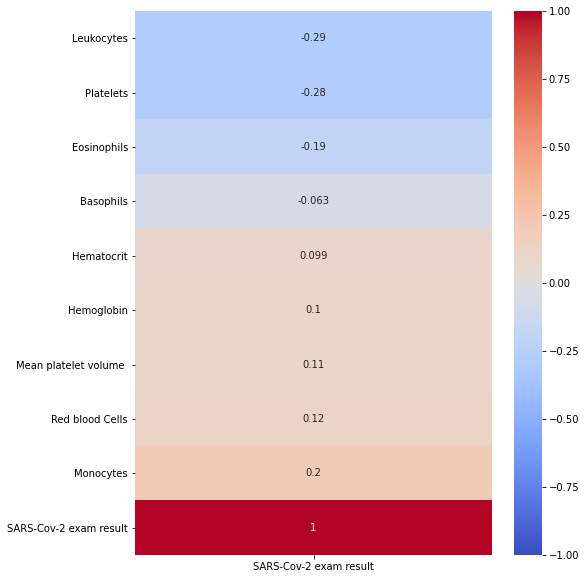

In [18]:
# plotting correlations with 'SARS-Cov-2 exam result' column
heatmap_numeric_w_dependent_variable(df1_new, 'SARS-Cov-2 exam result')

In [19]:
# defining features and target
X1 = df1_new.drop(['SARS-Cov-2 exam result'], axis=1)

y1 = df1_new['SARS-Cov-2 exam result']

In [20]:
# imputation of missing values with multivariate imputation algorithm
imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(X1)

X1 = imp.transform(X1)

In [21]:
# scaling X1
scaler = MinMaxScaler()

scaler.fit(X1)

X1 = scaler.transform(X1)

In [22]:
# train test split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=33)     

In [23]:
# LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)

clf.fit(X1_train, y1_train)

y1_pred = clf.predict(X1_test)

In [24]:
# cross-validation 
all_accuracies_clf_1 = cross_val_score(estimator=clf, X=X1_train, 
                                 y=y1_train, cv=5)

In [25]:
# mean accuracy and standard deviation
mean_acc_corrint = all_accuracies_clf_1.mean()*100
std_acc_corrint = all_accuracies_clf_1.std()

Now let's select features with a selector algorithm.

# **2. *SelectKBest***

In [26]:
# defining features and target
X2 = df1_dummy.drop(['SARS-Cov-2 exam result'], axis=1)

y2 = df1_dummy['SARS-Cov-2 exam result']

In [27]:
# I'll need this to apply SelectKBest algorithm 
X2_columns = X2.columns

In [28]:
# imputation of missing values with multivariate imputation algorithm
imp = IterativeImputer(max_iter=10, random_state=0)

imp.fit(X2)

X2 = imp.transform(X2)

/opt/conda/lib/python3.6/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [29]:
# scaling X2
scaler = MinMaxScaler()

scaler.fit(X2)

X2 = scaler.transform(X2)

In [30]:
# transforming X and y to DataFrame to apply SelectKbest and return the selected columns
y2 = pd.DataFrame(data=y2, columns=['SARS-Cov-2 exam result'])

X2 = pd.DataFrame(data=X2, columns=X2_columns) 

In [31]:
# applying
selector = SelectKBest(chi2, k=5)
selector.fit(X2, y2)

SelectKBest(k=5, score_func=<function chi2 at 0x7f0800cbb1e0>)

In [32]:
# selected columns
# thanks to: https://stackoverflow.com/questions/46927545/get-feature-names-of-selectkbest-function-python
X_new = selector.transform(X2)
print(X_new.shape)

X2.columns[selector.get_support(indices=True)]

vector_names = list(X2.columns[selector.get_support(indices=True)])
print(vector_names)

X2.columns[selector.get_support(indices=True)].tolist()

(5644, 5)
['Patient age quantile', 'Respiratory Syncytial Virus_detected', 'Rhinovirus/Enterovirus_detected', 'Inf A H1N1 2009_detected', 'Influenza A, rapid test_positive']


['Patient age quantile',
 'Respiratory Syncytial Virus_detected',
 'Rhinovirus/Enterovirus_detected',
 'Inf A H1N1 2009_detected',
 'Influenza A, rapid test_positive']

In [33]:
# assigning target
y_new = np.ravel(y2)

In [34]:
# train test split

X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y_new, 
                                                                    random_state=33)                                                                     
                                                                   

In [35]:
# LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5)

clf.fit(X_new_train, y_new_train)

y_new_pred = clf.predict(X_new_test)

In [36]:
# cross-validation 
all_accuracies_clf_2 = cross_val_score(estimator=clf, X=X_new_train, 
                                 y=y_new_train, cv=5)

In [37]:
# mean accuracy and standard deviation
mean_acc_selector = all_accuracies_clf_2.mean()*100
std_acc_selector = all_accuracies_clf_2.std()

# **Resuming the results:**

In [38]:
print('The average accuracy of the first model is', mean_acc_corrint, '%')
print('and the standard deviation is', std_acc_corrint,'.')
print()
print('The average accuracy of the second model is', mean_acc_selector, '%')
print('and the standard deviation is', std_acc_selector, '.')

The average accuracy of the first model is 90.12520898400976 %
and the standard deviation is 0.0005719437212361597 .

The average accuracy of the second model is 90.10159623312427 %
and the standard deviation is 0.00043999400470594205 .


As we saw above, both methods had good performance. But the first was a little better, proving that our intuition and knowledge of the world can be useful to obtain good results in models of Machine Learning.

Finally, it's always good to remember:

In [39]:
print('STAY HOME, IF YOU CAN.')

STAY HOME, IF YOU CAN.
